# BD04 - Predictive maintenance
## Casusgroep 7
### Dimitri Batchev, Dwayne Debets, Rade Grbić, Martijn Remmen en Peter Roijen
# Introductie
In dit project wordt er gekeken naar predictive maintenance. Het idee achter predictive maintenance is dat door het monitoren van apparatuur of machines met sensoren, de life (of fail) cycle gemanaged kan worden en zo uitval van machines op tijd aangepakt kan worden.
# Dataset
De gebruikte dataset bevat data van SSD's en HDD's per kwartaal, en de bijbehorende [SMART waardes](https://www.backblaze.com/blog/hard-drive-smart-stats/). 
De dataset is te vinden op [Backblaze](https://www.backblaze.com/b2/hard-drive-test-data.html).

# Libraries
De volgende libraries worden geïmporteerd om gebruik te maken van de functionaliteiten die deze libraries aanbieden.

In [2]:
# Pandas voor data import
import pandas as pd 

import os

# Matplotlib en Seaborn voor grafieken
import seaborn as sns
import matplotlib.pyplot as plt

# Importeren dataset
De dataset wordt geïmporteerd met de Pandas library.

In [3]:
prefix = 'data/'

sources = os.listdir(prefix)[0:10]

dataset = pd.concat([pd.read_csv(f'{prefix}{source}') for source in sources])
dataset = dataset.dropna(how='all')

In [4]:
dataset.shape

(3310205, 149)

In [14]:
dataset.info()
dataset.head()

dataset.model.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3310205 entries, 0 to 166363
Columns: 150 entries, date to smart_255_raw
dtypes: bool(1), float64(144), int64(2), object(3)
memory usage: 3.7+ GB


59

# Data cleaning
Om de data bruikbaar te maken, moeten er enkele aanpassingen gemaakt worden.

## Onderscheid maken tussen SSD en HDD
In de wereld van opslag wordt normaliter gewerkt met een tweetal soorten harde schijf types, namelijk **SSD** en **HDD**. Beide typen schijven hebben andere karakteristieken, meetwaardes en eigenschappen die ervoor kunnen zorgen dat failures plaatsvinden.



Om vast te stellen, uit de verkregen datasets en toekomstige datasets, welke harde schijf welk typen is zal een [S.M.A.R.T waarde](https://en.wikipedia.org/wiki/S.M.A.R.T.) gebruikt dienen te worden die aangeeft wat voor een type harde schijf het is. In totaliteit bestaan een groot aantal S.M.A.R.T waardes die ieder een ander atribuut aangeeft, evenals niet elke S.M.A.R.T waarde is aanwezig op elke harde schijf. De S.M.A.R.T waardes die aan kunnen geven wat voor een soort typen schijf het is luiden als volgt:



| ID | Description | Aanwezig* |
| :-: | ----------- | :---------------------------: |
| 03 | **Spin-Up Time** <br /> Geeft het gemiddelde tijd weer van de spindle spin up (RPM) in milliseconde. Dit geeft de mogelijkheid om aan te geven welke schijven HDDs zijn, aangezien SSDs gebruik maken van flash drives waardoor geen spindles gebruikt wordt. | ✔ |
| 171** | **SSD Program Fail Count** <br /> Het aantal keer dat het verwerken van data op flash memory gefaald is, dit kan het gevolgd hebben dat dit stuk flash niet meer bruikbaar is waardoor het read-only wordt. (SSD-only) |  |
| 172** | **SSD Erase Fail Count** <br /> Telt het aantal mislukte flash wistaken. Dit kenmerk returned het totale aantal mislukte flash-wisbewerkingen sinds de schijf is deployed. (SSD-only) |  |
| 173 | **SSD Wear leveling Count** <br /> Het maximum aantal wisbewerkingen dat is uitgevoerd op een enkel flash memory block. (SSD-only) | ✔ |
| 181 | **Program Fail Count** <br /> Hetzelfde als ID 171 | ✔ |
| 182 | **Erase Fail Count** <br /> Hetzelfde als ID 172 | ✔ |

*: Aanwezigheid value in Backblaze dataset  
**: Gebruikt door Kingston SSDs



### Conclusie



In theorie zouden alle bovenstaande waardes gebruikt kunnen worden om onderscheid te maken tussen SSDs en HDDs, echter dient de aangeleverde dataset wel deze waardes te bevatten. In het geval van de Backblaze datasets zijn een aantal waardes niet aanwezig. Middels het testen van waardes dient duidelijker te worden welke waardes het beste resultaat leveren.



---



In de dataset wordt er nog geen onderscheid gemaakt tussen SSD's en HDD's.

### SSD column toevoegen en alle values op False zetten

In [6]:
dataset.insert(2, "ssd", False, True)
dataset.head()

,date,serial_number,ssd,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-01-01,ZLW0EGC6,False,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,False,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,False,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,False,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,False,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Rows waar geld dat SMART waarde = ??? veranderen naar True (om te testen: als smart_1_normalized onder 100 zit, is het een SSD)

In [7]:
dataset.loc[dataset['smart_1_normalized'] < 100, 'ssd'] = True
# smart 173 none of null = hdd (174 en 177)
dataset.head(10)

,date,serial_number,ssd,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-01-01,ZLW0EGC6,True,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,False,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,True,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,False,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,True,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-01-01,20H0A0CXF97G,False,TOSHIBA MG07ACA14TA,14000519643136,0,100.0,0.0,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-01-01,ZA1FLE1P,True,ST8000NM0055,8001563222016,0,83.0,187371000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-01-01,ZA16NQJR,True,ST8000NM0055,8001563222016,0,83.0,205583648.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2021-01-01,ZJV02XWG,True,ST12000NM0007,12000138625024,0,82.0,168669824.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-01-01,ZA10Y8V6,True,ST8000DM002,8001563222016,0,84.0,226182392.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Verdeling modellen
Welke modellen zijn het meest in gebruik

<AxesSubplot:title={'center':'Meest voorkomende modellen (top 10)'}>

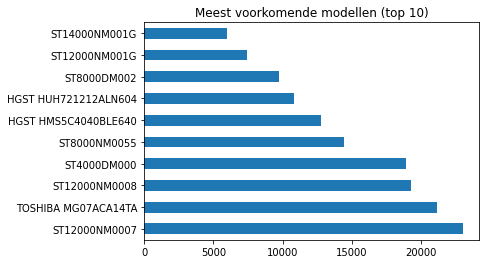

In [8]:
amount_models = dataset[['model', 'serial_number']].drop_duplicates('serial_number').model.value_counts()
amount_models.head(10).plot(kind='barh', title="Meest voorkomende modellen (top 10)")

# Failures per model

<AxesSubplot:title={'center':'Aantal failures per model (top 10)'}>

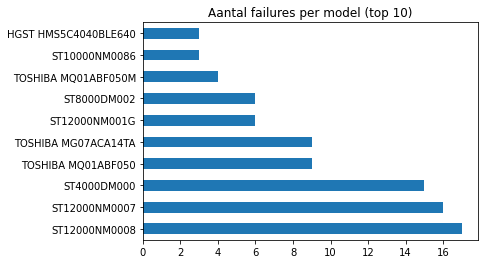

In [9]:
model_failures = dataset[['model', 'failure']][dataset.failure == 1].model.value_counts()
model_failures.head(10).plot(kind='barh', title="Aantal failures per model (top 10)")